## Generate Salpha plot, 
### We construct the time frequency map after whitening by a O3a data

In [1]:
from __future__ import division

import lal
import lalsimulation as lalsim
import pycbc.frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass_fir, resample_to_delta_t, sigmasq

import os, sys
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

from calndm import FindNonDimensionalFrequency
import utils
mUtils = utils.MiscellaneousUtils()

### Generate a HoM waveform of a nonspinning system and save in a file

In [2]:
mUtils.approx = 'SEOBNRv4HM'
mUtils.deltaT = 1.0/4096.0
mUtils.fmax = 0.5/mUtils.deltaT
mUtils.deltaF = 1.0/5.0

mUtils.fmin = 16.0

mUtils.tref = 4.0
mUtils.det = "L1"
mUtils.mass1 = 36.662310665079644
mUtils.mass2 = 10.475005235539586
mUtils.iota = 0.9


wf0 = mUtils._gen_waveform()



In [3]:
# length of the waveform should be less than mUtils.tref 
# otherwise crop the waveform
plt.plot(np.arange(wf0.data.length)*wf0.deltaT, wf0.data.data)

In [4]:
np.save( 'waveform.npy', wf0.data.data )

### Load the data and generate the $Y(\alpha)$ plot

In [5]:
wf1 = np.load( 'waveform.npy' )

## Set the parameters of the waveform
mUtils.approx = 'SEOBNRv4HM'
mUtils.deltaT = 1.0/4096.0
mUtils.fmax = 0.5/mUtils.deltaT
mUtils.deltaF = 1.0/5.0

mUtils.fmin = 15.0

mUtils.tref = 4.0
mUtils.det = "L1"
mUtils.mass1 = 36.662310665079644
mUtils.mass2 = 10.475005235539586
mUtils.iota = 0.9


In [6]:
## Resize the waveform and set the coalescence time at mUtils.tref

## One can use a frame file, use: pybc.frame.read
## wf = pycbc.frame.read_frame('waveform.gwf', 'G1:DER_DATA_H')

wf = pycbc.types.TimeSeries( wf1, delta_t=mUtils.deltaT )

# Multiply by Tukey window to taper at the start point.
wf.data *= mUtils._gen_tukey_window(len(wf), beta=0.05, start=True, end=False)

length = int(1.0/mUtils.deltaT/mUtils.deltaF)
wf.resize( length )


# Set the peak index at mUtils.tref
peak_indx = wf.abs_arg_max()
col_indx = int( mUtils.tref/mUtils.deltaT)
shift_indx = col_indx-peak_indx
wf.roll(shift_indx)

In [7]:
plt.plot(wf.sample_times, wf.data)

In [8]:
### Whiten the waveform using O3 psd

## 64 sec after the GW190412 event
mUtils.event_time = 1239082262.18 + 64.0
mUtils.det_event_time = 1239082262.18 + 64.0

# Loading the gravitational wave starin
half_length = 32
raw_strain = pycbc.frame.query_and_read_frame("L1_HOFT_C00", "L1:GDS-CALIB_STRAIN", \
        int(mUtils.det_event_time - half_length), int(mUtils.det_event_time + half_length))
L1 = resample_to_delta_t(raw_strain, mUtils.deltaT)

# Compute PSD
psd = interpolate(welch(L1), mUtils.deltaF)

In [9]:
whiten_wf = mUtils._whiten(wf, psd)

In [10]:
plt.plot( whiten_wf.sample_times, whiten_wf.data )

In [11]:
### Generate the time Frequency map
mUtils.cwt_fhigh= 600.0
mUtils.alpha_arr = np.linspace(0.2, 2.9, 541)
mUtils.ndm_freq = 15.0

cmplx_cwt, scales, freqs, coi, fftfreqs = mUtils._compute_cwt(whiten_wf)

# Take absolute square
wf_power = np.abs(cmplx_cwt)**2.0


In [28]:
### Generate the time-frequency track of the (2, 2) mode
# set a waverom, not necessary to be a HM waveform
mUtils.approx = 'IMRPhenomD'
fSchwarzISCO = 1.0 / ( 6.0**1.5 * lal.PI * (mUtils.mass1 + mUtils.mass2) * lal.MTSUN_SI )
mUtils.track_end_frequency = 0.6*fSchwarzISCO
mUtils.track_max_length = 0.5


tArrFixDT, fArrFixDT, interpF, interpT = \
           mUtils._gen_time_frequency_path(start_freq=mUtils.fmin)


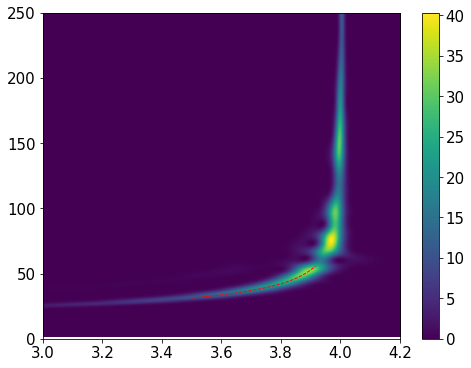

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow( wf_power , extent=[0.0, 1.0/mUtils.deltaF, freqs.min(), freqs.max()],\
            aspect='auto', origin='lower')
ax.plot(tArrFixDT, fArrFixDT, ls='--', c='r', lw=0.9)
#ax.plot(tArrFixDT, 1.5*fArrFixDT, ls='--', c='white', lw=0.5)
ax.set_ylim(0.0, 250)
ax.set_xlim(3.0, 4.2)
fig.colorbar(im)

In [30]:
## Generate S(\alpha) from TF map
Salpha = mUtils._stack_pixels_energies(wf_power, tArrFixDT, fArrFixDT, interpT)

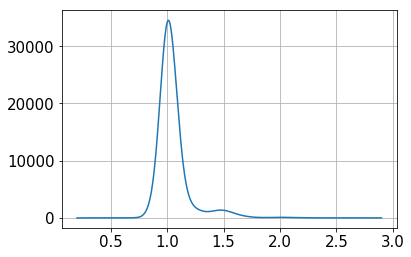

In [31]:
plt.plot(mUtils.alpha_arr, Salpha)
plt.grid(True)